# Category 1: Using existing data to make inferences about the creative process of the Royal Rumble match

We know ex ante that the Royal Rumble is a scripted event, i.e. that it is deterministic. The entrants are purported to be drawn at random. It *could* be the case that some, or all of the entrants are drawn at random, but it seems exceedingly unlikely given how critical specific storytelling elements are to the product. Anecdotally, I observed that many of the eliminations are between wrestlers in an existing feud, or one will emerge from the event. The first part of the analysis can look for predictions along this axis- how different do wrestlers' individual distributions on their entry number look compared to the discrete uniform distribution on {1,2,...,30}?
My suspicion is that the best predictor of winning the Royal Rumble is *how many eliminations that wrestler has,* as the winner is intended to be a strong character who is featured prominently in the biggest wrestling events of the year. What other factors outside of the 'kayfabe world' (kayfabe is an insider wrestling term, essentially meaning in-storyline) determine whether or not an entrant will perform well or poorly? 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
RUMBLE_DATA = pd.read_csv('/home/christian/Desktop/Royal_Rumble_Analysis/RumbleData.csv').copy()

def time_cleaner(time_string):
    """
    Convert video timestamps into seconds
    """
    return 3600*int(time_string[0]) + 60*int(time_string[1]) + int(time_string[2])

RUMBLE_DATA['entry_time'] = RUMBLE_DATA['entry_time'].astype(str)
RUMBLE_DATA['exit_time'] = RUMBLE_DATA['exit_time'].astype(str)
ENTRY_TIME_SPLIT = RUMBLE_DATA['entry_time'].str.split(':')
EXIT_TIME_SPLIT = RUMBLE_DATA['exit_time'].str.split(':')

RUMBLE_DATA['entry_time'] = ENTRY_TIME_SPLIT.apply(time_cleaner)
RUMBLE_DATA['exit_time'] = EXIT_TIME_SPLIT.apply(time_cleaner)

for year in RUMBLE_DATA['year'].unique():
    RUMBLE_DATA.loc[RUMBLE_DATA['year'] == year, 'exit_time'] = (RUMBLE_DATA.loc[RUMBLE_DATA['year'] == year, 'exit_time'] -
                                                                RUMBLE_DATA.loc[RUMBLE_DATA['year'] == year, 'entry_time'].min())

    RUMBLE_DATA.loc[RUMBLE_DATA['year'] == year, 'entry_time'] = (RUMBLE_DATA.loc[RUMBLE_DATA['year'] == year, 'entry_time'] -
                                                                  RUMBLE_DATA.loc[RUMBLE_DATA['year'] == year, 'entry_time'].min())

    
RUMBLE_DATA['total_time'] = RUMBLE_DATA['exit_time'] - RUMBLE_DATA['entry_time']
RUMBLE_DATA['total_elim'] = (RUMBLE_DATA['solo_elim'] + RUMBLE_DATA['group_elim'] + 
                             RUMBLE_DATA['illegal_elim'])

RUMBLE_DATA['tag_partner'] = RUMBLE_DATA['tag_partner'].fillna(0)
RUMBLE_DATA.fillna(0)
MATCH_DATA = pd.DataFrame()

state_dict = {}

for year in RUMBLE_DATA['year'].unique():
    year_state_dict = {}
    entry_times = RUMBLE_DATA.loc[RUMBLE_DATA['year'] == year, 'entry_time'].unique().tolist()
    exit_times = RUMBLE_DATA.loc[RUMBLE_DATA['year'] == year, 'exit_time'].unique().tolist()
    split_times = entry_times + exit_times
    split_times.sort()
    entry_times.sort()
    exit_times.sort()
    for time in split_times:
        state_vec = np.zeros(30)
        for wrestler in RUMBLE_DATA.loc[RUMBLE_DATA['year'] == year, 'name']:
            entry_number = int(RUMBLE_DATA.loc[(RUMBLE_DATA['year'] == year) & (RUMBLE_DATA['name'] == wrestler), 'entry_num'])
            time_in = int(RUMBLE_DATA.loc[(RUMBLE_DATA['year'] == year) & (RUMBLE_DATA['name'] == wrestler), 'entry_time'])
            time_out = int(RUMBLE_DATA.loc[(RUMBLE_DATA['year'] == year) & (RUMBLE_DATA['name'] == wrestler), 'exit_time'])
            if time_in <= time and time_out > time:
                state_vec[entry_number - 1] = 1
        year_state_dict[time] = state_vec
    state_dict[year] = year_state_dict
    year_list = []
    for i in range(len(split_times)):
        year_list.append(year)
    year_series = pd.Series(year_list)
    split_series = pd.Series(split_times)
    entry_series = pd.Series(entry_times)
    exit_series = pd.Series(exit_times)
    year_split = pd.concat([year_series, split_series, entry_series, exit_series], axis=1)
    MATCH_DATA = pd.concat([MATCH_DATA, year_split], axis=0)

MATCH_DATA.columns = ['year', 'split', 'entry_split', 'exit_split']

for wrestler in RUMBLE_DATA['name'].unique():
    year_count = 0
    elim_count = 0
    time_count = 0
    app_count = 0
    for year in RUMBLE_DATA.loc[RUMBLE_DATA['name'] == wrestler, 'year']:
        RUMBLE_DATA.loc[(RUMBLE_DATA['name'] == wrestler) &
                                (RUMBLE_DATA['year']== year), 'prev_app'] = year_count
        year_count += 1
        elim_count += int(RUMBLE_DATA.loc[(RUMBLE_DATA['name'] == wrestler) &
                                        (RUMBLE_DATA['year']== year), 'total_elim'])
        time_count += int(RUMBLE_DATA.loc[(RUMBLE_DATA['name'] == wrestler) &
                                        (RUMBLE_DATA['year']== year), 'total_time'])
        RUMBLE_DATA.loc[(RUMBLE_DATA['name'] == wrestler) &
                                (RUMBLE_DATA['year']== year), 'cum_elim'] = elim_count
        RUMBLE_DATA.loc[(RUMBLE_DATA['name'] == wrestler) &
                                (RUMBLE_DATA['year']== year), 'avg_cum_elim'] = elim_count/year_count
        RUMBLE_DATA.loc[(RUMBLE_DATA['name'] == wrestler) &
                                (RUMBLE_DATA['year']== year), 'cum_time'] = time_count
        RUMBLE_DATA.loc[(RUMBLE_DATA['name'] == wrestler) &
                                (RUMBLE_DATA['year']== year), 'avg_cum_time'] = time_count/year_count

for year in MATCH_DATA['year'].unique():
    rumble_states = state_dict[year]
    i = 1
    index = 0
    splits = MATCH_DATA.loc[MATCH_DATA['year'] == year, 'split']
    for time in splits[1:]:
        while i < time:
            rumble_states[i] = rumble_states[splits[index]]
            num_in = (i,np.count_nonzero(rumble_states[splits[index]]))
            i += 1
        index +=1

RUMBLE_DATA.to_csv('/home/christian/Desktop/Royal_Rumble_Analysis/Rumble_Data_Cleaned.csv')
MATCH_DATA.to_csv('/home/christian/Desktop/Royal_Rumble_Analysis/Match_Data.csv')


From randomly sampling the different wrestlers, I was able to hone in on a couple of important trends. For some wrestlers, the distribution looks *reasonably* random. You can discern a pattern from the distribution below, but it's not terribly strong.

(1988, 1997)

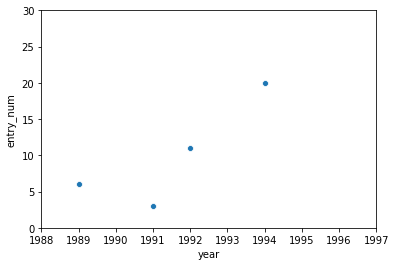

In [3]:
sns.scatterplot(x = 'year', y = 'entry_num', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Greg Valentine'])
plt.ylim(0,30)
plt.xlim(1988,1997)


For others, not so much. The two sets of plots below are for Jimmy Snuka and Tatanka respectively. Jimmy Snuka's prime was in the 70's and early 80's, whereas Tatanka was a wrestler who was consistently an undercard or midcard act. In either case, these are wrestlers that the fans *know* are not going to win the Royal Rumble- who don't stand a reasonable chance of winning, and who aren't going to make many eliminations. These wrestlers won't typically appear in the match for a long time- it's their job to make the big names look good. The first plot shows their entry number in each year that they entered, while the next plot has their entry number stacked next to their eliminations and the amount of time they spend in the match.

(1988, 1997)

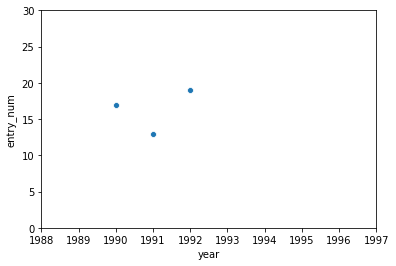

In [4]:
sns.scatterplot(x = 'year', y = 'entry_num', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Jimmy Snuka'])
plt.ylim(0,30)
plt.xlim(1988,1997)


A very tight cluster in the middle.

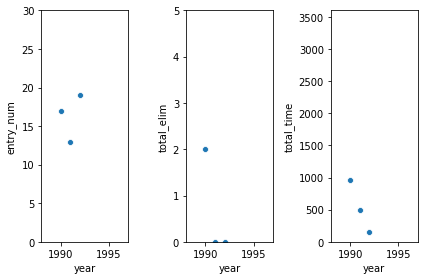

In [5]:
plt.subplot(1,3,1)
sns.scatterplot(x = 'year', y = 'entry_num', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Jimmy Snuka'])
plt.ylim(0,30)
plt.xlim(1988,1997)

plt.subplot(1,3,2)
sns.scatterplot(x = 'year', y = 'total_elim', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Jimmy Snuka'])
plt.ylim(0,5)
plt.xlim(1988,1997)

plt.subplot(1,3,3)
sns.scatterplot(x = 'year', y = 'total_time', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Jimmy Snuka'])
plt.xlim(1988,1997)
plt.ylim(0,3600)
plt.tight_layout()

(1988, 1997)

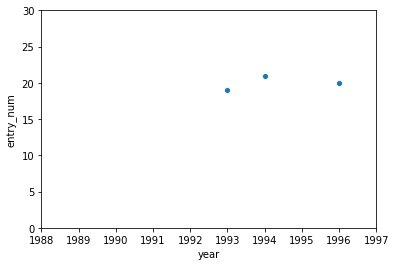

In [6]:
sns.scatterplot(x = 'year', y = 'entry_num', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Tatanka'])
plt.ylim(0,30)
plt.xlim(1988,1997)

Small samples can do strange things, but I'm very skeptical that Tatanka was randomly drawn into this cluster! 

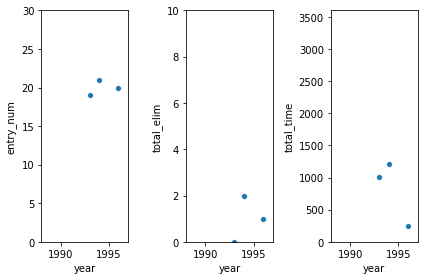

In [7]:
plt.subplot(1,3,1)
sns.scatterplot(x = 'year', y = 'entry_num', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Tatanka'])
plt.ylim(0,30)
plt.xlim(1988,1997)

plt.subplot(1,3,2)
sns.scatterplot(x = 'year', y = 'total_elim', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Tatanka'])
plt.ylim(0,10)
plt.xlim(1988,1997)

plt.subplot(1,3,3)
sns.scatterplot(x = 'year', y = 'total_time', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Tatanka'])
plt.xlim(1988,1997)
plt.ylim(0,3600)
plt.tight_layout()

We can contrast this with Bret Hart and Shawn Michaels, who are two of the most famous and successful wrestlers of this era. Both won Royal Rumbles (Hart in '94, Michaels in '95 and '96), but both also spend the late 80's and early 90's as members of tag teams- not at the top of the card. There are gaps missing for Bret Hart due to his having other prominent matches on the Royal Rumble card in the years 1989, 1993, 1995, and 1996, and similarly for Shawn Michaels in 1991 and 1993.

(1988, 1997)

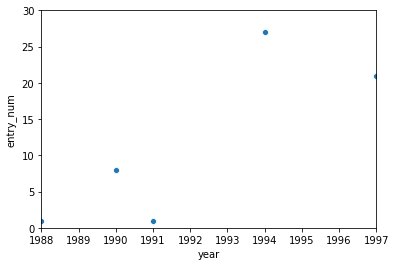

In [8]:
sns.scatterplot(x = 'year', y = 'entry_num', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Bret Hart'])
plt.ylim(0,30)
plt.xlim(1988,1997)


What we observe here is a trend that seems to appear for many of the big names- a sort of bifurcation. These wrestlers tend to appear in the very beginning or towards the very end of the Royal Rumble.

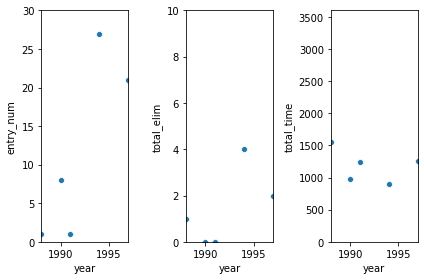

In [9]:
plt.subplot(1,3,1)
sns.scatterplot(x = 'year', y = 'entry_num', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Bret Hart'])
plt.ylim(0,30)
plt.xlim(1988,1997)

plt.subplot(1,3,2)
sns.scatterplot(x = 'year', y = 'total_elim', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Bret Hart'])
plt.ylim(0,10)
plt.xlim(1988,1997)

plt.subplot(1,3,3)
sns.scatterplot(x = 'year', y = 'total_time', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Bret Hart'])
plt.xlim(1988,1997)
plt.ylim(0,3600)
plt.tight_layout()

Now, the scale is the same across all of these plots- Bret Hart's total time in the Royal Rumble was, in general, between 1000 and 1500 seconds (16-25 minutes). Tatanka's times above are certainly, and statistically significantlly worse than this- but not *drastically* so. A close look at the dataframe might help inform our analysis.

In [10]:
RUMBLE_DATA.loc[(RUMBLE_DATA['name'] == 'Bret Hart') | (RUMBLE_DATA['name'] == 'Tatanka')]

,year,entry_num,exit_num,name,entry_time,exit_time,total_time,elim_by,solo_elim,group_elim,...,cum_time,avg_cum_time,prev_app,us_champ,cruise_champ,euro_champ,break_begin,break_end,total_break,total_elim
0,1988,1,8,Bret Hart,0,1546,1546,Don Muraco,0,1,...,1546.0,1546.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1
57,1990,8,9,Bret Hart,721,1699,978,Dusty Rhodes,0,0,...,2524.0,1262.000000,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0
80,1991,1,4,Bret Hart,0,1238,1238,The Undertaker,0,0,...,3762.0,1254.000000,2.0,0.0,NaN,NaN,NaN,NaN,NaN,0
158,1993,19,20,Tatanka,2073,3086,1013,Yokozuna,0,0,...,1013.0,1013.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
190,1994,21,23,Tatanka,1807,3016,1209,Bam Bam Bigelow,1,1,...,2222.0,1111.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2
196,1994,27,29,Bret Hart,2409,3307,898,Lex Luger,2,2,...,4660.0,1165.000000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4
249,1996,20,17,Tatanka,2213,2461,248,Diesel,1,0,...,2470.0,823.333333,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1
280,1997,21,29,Bret Hart,1767,3027,1260,Stone Cold Steve Austin,2,0,...,5920.0,1184.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2


Some of the  qualitative differences jump out immediately.  In the years 1993 and 1994, Tatanka spent 15-18 or so minutes in the Royal Rumble, but didn't seem to do anything too significant in that time- he had 2 eliminations in 1994, but his entry number never drifts very far from his exit number. There are two important observations therein. One is that, as entry number increases, the floor on your exit number increases. If you are the last entrant, as Duke Droese in 1996 (a literal wrestling garbage man), you will necessarily have a higher exit number than a significant proportion than those who came before you. This means that we *have to derive a performance metric that normalizes time spent in the ring.* This is imperative if we want to use time series elements to try and predict the *entry* order. Some wrestlers are trusted to spend a great deal of time in the ring and act as a general- and we would anticipate wrestlers who fit that mold to be entered earlier than later. If the trend that's appeared in this small portion of the data continues- i.e. that the star athletes will enter in the beginning or in the end, that should be reflected in the regression predictions.

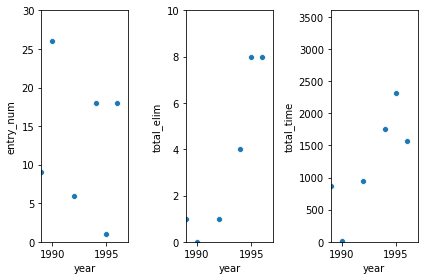

In [11]:
plt.subplot(1,3,1)
sns.scatterplot(x = 'year', y = 'entry_num', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Shawn Michaels'])
plt.ylim(0,30)
plt.xlim(1989,1997)

plt.subplot(1,3,2)
sns.scatterplot(x = 'year', y = 'total_elim', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Shawn Michaels'])
plt.ylim(0,10)
plt.xlim(1989,1997)

plt.subplot(1,3,3)
sns.scatterplot(x = 'year', y = 'total_time', data = RUMBLE_DATA.loc[RUMBLE_DATA['name'] == 'Shawn Michaels'])
plt.xlim(1989,1997)
plt.ylim(0,3600)
plt.tight_layout()

In [12]:
import category_encoders

In [13]:
RUMBLE_DATA.columns

Index(['year', 'entry_num', 'exit_num', 'name', 'entry_time', 'exit_time',
       'total_time', 'elim_by', 'solo_elim', 'group_elim', 'illegal_elim',
       'alignment', 'tag_overlap', 'tag_team', 'tag_partner', 'illegal_exit',
       'accidental_exit', 'cum_elim', 'avg_cum_elim', 'world_champ',
       'Unnamed: 20', 'cum_time', 'avg_cum_time', 'prev_app', 'us_champ',
       'cruise_champ', 'euro_champ', 'break_begin', 'break_end', 'total_break',
       'total_elim'],
      dtype='object')

Trying to predict the entry is a fairly sophisticated time series problem- I only found one paper about ordinal time series models, and it's fairly recent. That being said, we can just try some of the inputs across a host of different encoding structures and GLM models and see what sticks.

In [14]:
X = RUMBLE_DATA[['year','name','alignment', 'cum_elim', 'avg_cum_elim', 
                 'world_champ', 'cum_time', 'avg_cum_time']]

y = RUMBLE_DATA['entry_num']

We want to come up with metrics that we will have access to going into a forthcoming Royal Rumble- it will be perfectly easy for the model to predict entrance number based on exit number, who eliminated who, etc. Hence the models below:

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split

X_train = RUMBLE_DATA[['year','name','alignment', 'cum_elim', 'avg_cum_elim', 
                 'world_champ', 'cum_time', 'avg_cum_time']][20:230]
X_test = RUMBLE_DATA[['year','name','alignment', 'cum_elim', 'avg_cum_elim', 
                 'world_champ', 'cum_time', 'avg_cum_time']][230:]

y_train = RUMBLE_DATA['entry_num'][20:230]
y_test = RUMBLE_DATA['entry_num'][230:]

enc = OneHotEncoder(handle_unknown = 'ignore')

enc.fit(X_train)
encoded_X_train = enc.transform(X_train)

encoded_X_test = enc.transform(X_test)
reg = LinearRegression().fit(encoded_X_train,y_train)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
reg.score(encoded_X_test,y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train = RUMBLE_DATA[['year','name','alignment', 'cum_elim', 'avg_cum_elim', 
                 'world_champ', 'cum_time', 'avg_cum_time']][20:230]
X_test = RUMBLE_DATA[['year','name','alignment', 'cum_elim', 'avg_cum_elim', 
                 'world_champ', 'cum_time', 'avg_cum_time']][230:]

y_train = RUMBLE_DATA['entry_num'][20:230]
y_test = RUMBLE_DATA['entry_num'][230:]

enc = OneHotEncoder(handle_unknown = 'ignore')

enc.fit(X_train)
enc.fit(X_test)
encoded_X_train = enc.transform(X_train)
encoded_X_test = enc.transform(X_test)

reg = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial').fit(encoded_X_train,y_train)

reg.score(encoded_X_test,y_test)

In [ ]:
import mord

X_train = RUMBLE_DATA[['year','name','alignment', 'cum_elim', 'avg_cum_elim', 
                 'world_champ', 'cum_time', 'avg_cum_time']][20:230]
X_test = RUMBLE_DATA[['year','name','alignment', 'cum_elim', 'avg_cum_elim', 
                 'world_champ', 'cum_time', 'avg_cum_time']][230:]

y_train = RUMBLE_DATA['entry_num'][20:230]
y_test = RUMBLE_DATA['entry_num'][230:]

enc.fit(X_train)
enc.fit(X_test)
encoded_X_train = enc.transform(X_train)
encoded_X_test = enc.transform(X_test)

clf = mord.LogisticIT(1.0)

clf.fit(encoded_X_train,y_train)

clf.predict(encoded_X_test)

clf.score(encoded_X_test, y_test)




In [3]:
RUMBLE_DATA['win'] = 0
RUMBLE_DATA.loc[RUMBLE_DATA['elim_by'] == 'Winner', 'win'] = 1


In [6]:
keys= []
for i in range(1,31):
    keys.append('in_' + str(i))

for key in keys:
    RUMBLE_DATA[key] = 0
    
for i in range(1,31):
    RUMBLE_DATA.loc[RUMBLE_DATA['entry_num'] == i, keys[i-1]] = 1

In [7]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

X_train = RUMBLE_DATA[keys][20:230]
X_test = RUMBLE_DATA[keys][230:]
y_train = RUMBLE_DATA['exit_num'][20:230]                     
y_test = RUMBLE_DATA['exit_num'][230:]                   

clf.fit(X_train,y_train)

clf.predict(X_test)

array([ 4,  1,  2,  3,  2,  7,  6,  7,  8,  5,  5,  4, 13, 12, 14, 11, 17,
       15, 14, 17, 23, 18, 20, 16, 23, 20, 30, 22, 27, 29,  4,  1,  2,  3,
        2,  7,  6,  7,  8,  5,  5,  4, 13, 12, 14, 11, 17, 15, 14, 17, 23,
       18, 20, 16, 23, 20, 30, 22, 27, 29,  4,  1,  2,  3,  2,  7,  6,  7,
        8,  5,  5,  4, 13, 12, 14, 11, 17, 15, 14, 17, 23, 18, 20, 16, 23,
       20, 30, 22, 27, 29,  4,  1,  2,  3,  2,  7,  6,  7,  8,  5,  5,  4,
       13, 12, 14, 11, 17, 15, 14, 17, 23, 18, 20, 16, 23, 20, 30, 22, 27,
       29,  4,  1,  2,  3,  2,  7,  6,  7,  8,  5,  5,  4, 13, 12, 14, 11,
       17, 15, 14, 17, 23, 18, 20, 16, 23, 20, 30, 22, 27, 29,  4,  1,  2,
        3,  2,  7,  6,  7,  8,  5,  5,  4, 13, 12, 14, 11, 17, 15, 14, 17,
       23, 18, 20, 16, 23, 20, 30, 22, 27, 29])

In [8]:
clf.score(X_test,y_test)

0.08888888888888889

# Category 2: Using existing data to create a win probability model and match simulator

This is the interesting philosophical question- is the WWE's creative process capabale of creating cogent randomness? What properties does a simulated wrestling match have in common with a traditional sport, or even a 'real' combat sport like boxing or wrestling? Could we create a betting model given the probabilities we come up with? In an ideal world it would be great to have a model that would do live updating- i.e. when the first two entrants are in, it will return win probabilities for the contestants who have yet to enter given all possible premutations. After any elimination or exit, the model should update to reflect the state by assigning zero probability to the eliminated people (and, given the polarization of contestants, I think that the vast majority of the probability will be concentrated among a few entrants.)

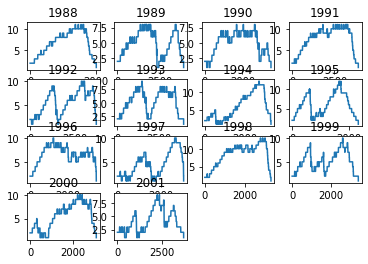

In [6]:
columns = 4
row = 4 
counter = 1
for year in MATCH_DATA['year'].unique():
    rumble_states = state_dict[year]
    wrestlers_in_xy = []
    i = 1
    index = 0
    splits = MATCH_DATA.loc[MATCH_DATA['year'] == year, 'split']

    for time in splits[1:]:
        while i < time:
            num_in = (i,np.count_nonzero(rumble_states[splits[index]]))
            wrestlers_in_xy.append(num_in)
            i += 1
        index +=1
    
    wrestlers_in_xy.append((0,2))
    wrestlers_in_xy.append((splits[len(splits)-1],1))
    
    ax = plt.subplot(row,columns,counter)
    ax.title.set_text(str(year))
    sns.lineplot(*zip(*wrestlers_in_xy))
    
    counter += 1
        
plt.rcParams['figure.figsize'] = [400, 400]

plt.show()

The plots above track the number of wrestlers in the ring at any given time t, and there is a plot for each year.

In [10]:
from pomegranate import *
import itertools

In [11]:
state_list = [(key,value) for key, value in state_dict[1989].items()]

vec_sequence = [y for x,y in state_list]

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a
    
vec_tuples = totuple(vec_sequence)

In [29]:
numbers_in_dict = {}

for year in MATCH_DATA['year'].unique():
    rumble_states = state_dict[year]
    wrestlers_in_xy = []
    i = 1
    index = 0
    splits = MATCH_DATA.loc[MATCH_DATA['year'] == year, 'split']

    for time in splits[1:]:
        while i < time:
            num_in = (i,np.count_nonzero(rumble_states[splits[index]]))
            wrestlers_in_xy.append(num_in)
            i += 1
        index +=1
    
    wrestlers_in_xy.append((0,2))
    wrestlers_in_xy.append((splits[len(splits)-1],1))
    
    numbers_in_dict[year]= wrestlers_in_xy

In [39]:
numbers_in_list = [y for (x,y) in numbers_in_dict[1989]]

print(numbers_in_list[165])


3


In [45]:
from hmmlearn.hmm import MultinomialHMM

In [100]:
simple_model89 = hmmlearn.hmm.MultinomialHMM(n_components = 30).fit(numbers_in_dict[1989])

In [101]:
simple_model89.transmat_

array([[0.0077082 , 0.00988974, 0.03262945, 0.05443542, 0.08764742,
        0.05357198, 0.00967965, 0.02470398, 0.03882183, 0.05722085,
        0.04017106, 0.0065209 , 0.05364572, 0.00654351, 0.02181455,
        0.01027845, 0.06591427, 0.05681642, 0.00763941, 0.0567986 ,
        0.11487625, 0.00462278, 0.00745014, 0.02029227, 0.01205018,
        0.02850226, 0.02517676, 0.00851173, 0.03906699, 0.03699923],
       [0.01066171, 0.01282302, 0.03661189, 0.06184042, 0.08278047,
        0.04814472, 0.01307912, 0.02372149, 0.03658601, 0.04872183,
        0.03975271, 0.00957675, 0.04286344, 0.00833522, 0.02458529,
        0.01335904, 0.06668418, 0.05220279, 0.00859628, 0.05266176,
        0.11548216, 0.00643858, 0.00942312, 0.02138348, 0.01531825,
        0.0282034 , 0.02636409, 0.01075269, 0.03600003, 0.03704604],
       [0.03704053, 0.03825367, 0.0289127 , 0.02945041, 0.02679363,
        0.02693885, 0.03644815, 0.03368223, 0.02434888, 0.02514398,
        0.0295105 , 0.0412103 , 0.0262114 , 0.

# Some Visualizations

In [4]:
from sklearn.cluster import KMeans

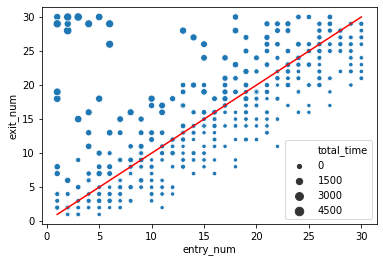

In [13]:
sns.scatterplot(x = 'entry_num', y = 'exit_num', size = 'total_time', data = RUMBLE_DATA)

x_plot = np.linspace(1,30)
y_plot = x_plot
plt.plot(x_plot, y_plot, color = 'r')

plt.show()



The figure above shows a pretty strong linear relationship between the entry and exit numbers. The size indicates the time that the contestant spent in the Royal Rumble- and we can see that the outliers are those who spend the longest time in, entering early and exiting late. When creating a win probability model, we really want to be able to identify and confidently predict observations like the upper left quadrant of this image- those most likely to stay in for an extended period of time and either threaten to or outright win the match.

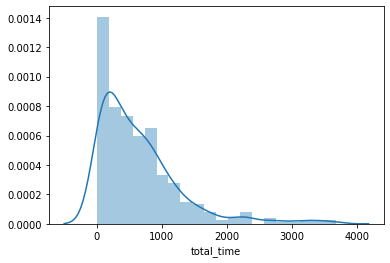

In [7]:
sns.distplot(RUMBLE_DATA['total_time'])

This density plot suggests a similar idea. Those who have the capability of holding their own and staying in the match for long periods of time are rare relative to the majority of the distribution, which consists of wrestlers who stay in for short periods of time and have few eliminations.

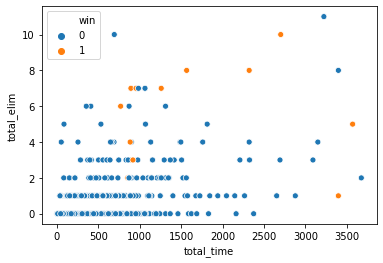

In [11]:
sns.scatterplot(x = 'total_time', y = 'total_elim', hue = 'win', data = RUMBLE_DATA)

This scatterplot actually shows an interesting foible- that those with the most eliminations *tend* to be in the match for longer, although not drastically so. One interesting thing to point out is the orange point in the bottom right corner- the data needs to be cleaned a bit more to account for the fact that, in certain years, there have been wrestlers who spent large swarths of time *outside* of the ring without being eliminated by using the rules loophole that you *can only be eliminated by going over the top rope.* (I am still entering this data but have it logged). The time spent in the match by those who win varies quite considerably, but they all (generally) have significantly more eliminations than the rest of the pack. If we can cogently predict a wrestler's potential number of eliminations, that will bear an enormous weight on their likelihood to win. 

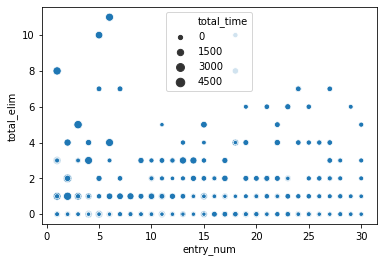

In [14]:
sns.scatterplot(x = 'entry_num', y = 'total_elim', size = 'total_time', data = RUMBLE_DATA)

Now *this* is interesting- apart from a few outliers, entry number appears to be largely uncorrelated with number of eliminations. With more data, it may be the case that the two modes at the extreme ends of entry number may separate from a valley. If this is the case, (and again, assuming this is a real contset) we can infer that the high elimination numbers from the early entry numbers come from those who have more opportunities and who are highly skilled, whereas those at the end come in fresh and go to battle with the already-tired contestants. I expect that trend to not be strong- because we know that the high elimination numbers are allocated to the wrestlers who are *supposed to look good according to the storyline,* which isn't necessarily associated with any particular entry number ex ante.

In [16]:
from sklearn import preprocessing

km = KMeans(n_clusters = 3, init = 'random', n_init = 10)

X = RUMBLE_DATA[['total_time','total_elim']]

x = X.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)
y_km = km.fit_predict(X)

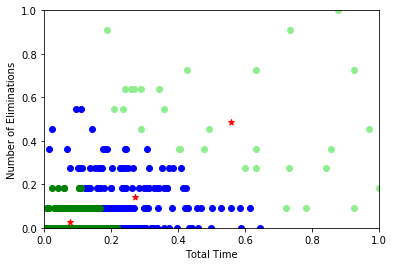

In [17]:
ax1 = plt.scatter(X[y_km == 0].iloc[:,0], X[y_km == 0].iloc[:,1] , c = 'blue')

ax2 = plt.scatter(X[y_km == 1].iloc[:,0], X[y_km == 1].iloc[:,1], c = 'green')

ax3 = plt.scatter(X[y_km == 2].iloc[:,0], X[y_km == 2].iloc[:,1], c = 'lightgreen')

ax4 = plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], c = 'red', marker = '*')

#plt.scatter(X[y_km == 3].iloc[:,0], X[y_km == 3].iloc[:,1], c = 'brown')

plt.rcParams['figure.figsize'] = [5, 5]
plt.xlabel('Total Time')
plt.ylabel('Number of Eliminations')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

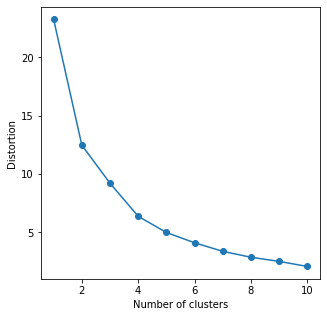

In [18]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

The clustering here doesn't paint a great picture at 3- we can see the separation among the scaled data, and it's either far too tightly packed or not packed enough even with normalized data. The elbow plot suggests that 4 might work a bit better.

In [23]:
X = RUMBLE_DATA[['total_time','total_elim']]

km = KMeans(n_clusters = 4, init = 'random', n_init = 10)
x = X.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)
y_km = km.fit_predict(X)

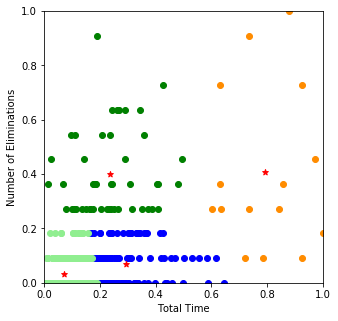

In [27]:
ax1 = plt.scatter(X[y_km == 0].iloc[:,0], X[y_km == 0].iloc[:,1] , c = 'blue')

ax2 = plt.scatter(X[y_km == 1].iloc[:,0], X[y_km == 1].iloc[:,1], c = 'green')

ax3 = plt.scatter(X[y_km == 2].iloc[:,0], X[y_km == 2].iloc[:,1], c = 'lightgreen')

ax4 = plt.scatter(X[y_km == 3].iloc[:,0], X[y_km == 3].iloc[:,1], c = 'darkorange')

ax5 = plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], c = 'red', marker = '*')

plt.rcParams['figure.figsize'] = [5, 5]
plt.xlabel('Total Time')
plt.ylabel('Number of Eliminations')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

Again, lots of spread, but we can identify the four centers. The teal group is for the worst of the bunch- little time and few eliminations. Meanwhile, the blue group lasts longer but also consists of wrestlers with few eliminations. The dark green and dark orange groups separate the best-performing wrestlers by how much time they spend in the match- they have largely similar performance metrics, but their 'random' draw into the match dictates how much time they spend in.

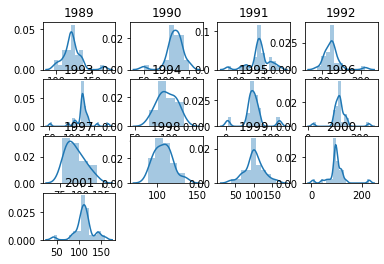

In [3]:
columns = 4
row = 4 
counter = 1
entry_split_by_year = {}
for year in MATCH_DATA.loc[MATCH_DATA['year'] != 1988, 'year'].unique():

    entries = []
    i = 1
    num_splits = len(MATCH_DATA.loc[MATCH_DATA['year'] ==year, 'entry_split'])
    splits = MATCH_DATA.loc[MATCH_DATA['year'] == year, 'entry_split'][1:29].to_list()
    for i in range(len(splits)):
        if i == 0:
            entries.append(splits[i])
        else:
            entries.append(splits[i] - splits[i-1])
           
    ax = plt.subplot(row,columns,counter)
    ax.title.set_text(str(year))
    sns.distplot(entries)
    counter +=1 

plt.show()



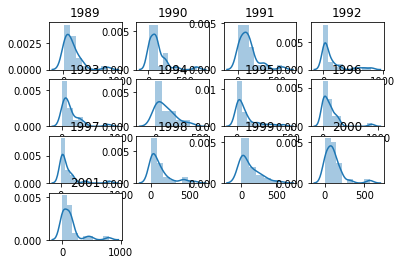

In [8]:
columns = 4
row = 4 
counter = 1

for year in MATCH_DATA.loc[MATCH_DATA['year'] != 1988, 'year'].unique():

    exits = []
    i = 1
    splits = MATCH_DATA.loc[(MATCH_DATA['year'] == year) &
                                    (MATCH_DATA['exit_split'].isna() == False), 'exit_split']
    num_splits = len(splits)
    for i in range(len(splits)):
        if i == 0:
            exits.append(splits[i])
        else:
            exits.append(splits[i] - splits[i-1])
           
    ax = plt.subplot(row,columns,counter)
    ax.title.set_text(str(year))
    sns.distplot(exits)
    counter +=1 

plt.show()
